In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D,Input,BatchNormalization
from tensorflow.keras.applications import ResNet50,MobileNetV2,EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/PES_hackathon/Deeplearning'
train_csv_path = f'{base_path}/train.csv'
test_csv_path = f'{base_path}/test.csv'
train_image_path = f'{base_path}/dataset/train'
test_image_path = f'{base_path}/dataset/test'

In [ ]:
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

In [ ]:
train_csv['label'] = train_csv['label'].astype(str)
train_csv['file_id'] = train_csv['file_id'].astype(str)

In [ ]:
train_csv['file_id'] = train_csv['file_id'] + '.jpg'
train_csv['file_id'] = train_csv.apply(lambda row: os.path.join(row['label'], row['file_id']), axis=1)

In [ ]:
test_csv['file_id'] = test_csv['file_id'].astype(str)
test_csv['file_id'] = test_csv['file_id'] + '.jpg'

In [ ]:
train_csv.head()
# fake = 0
# real = 1

,file_id,label
0,0/0.jpg,0
1,0/1.jpg,0
2,0/2.jpg,0
3,0/3.jpg,0
4,0/4.jpg,0


In [ ]:
train_df, val_df = train_test_split(train_csv, test_size=0.2, stratify=train_csv['label'])

In [ ]:
train_csv.shape

(1709, 2)

In [ ]:
train_df.shape

(1367, 2)

In [ ]:
val_df.shape

(342, 2)

In [ ]:
image_size = (128, 128)
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# train_generator = train_datagen.flow_from_dataframe(
#     train_df,
#     directory=train_image_path,
#     x_col='file_id',
#     y_col='label',
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='training'
# )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_image_path,
    x_col='file_id',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1367 validated image filenames belonging to 2 classes.


In [ ]:
validation_generator = train_datagen.flow_from_dataframe(
    val_df,
    directory=train_image_path,
    x_col='file_id',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 342 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_csv,
    directory=test_image_path,
    x_col='file_id',
    y_col=None,
    target_size=image_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 332 validated image filenames.


In [ ]:
#inputs = Input(shape=(128, 128, 3))

In [ ]:
model = Sequential()

# Add MobileNetV2 base model
mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model.add(mobilenet_v2)

# Add GlobalAveragePooling2D
model.add(GlobalAveragePooling2D())

# Add more layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', dtype='float32'))

In [ ]:
for layer in mobilenet_v2.layers[-20:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
85/85 [==============================] - 139s 1s/step - loss: 1.0397 - accuracy: 0.5137 - val_loss: 0.7274 - val_accuracy: 0.5149 - lr: 1.0000e-04
Epoch 2/30
85/85 [==============================] - 112s 1s/step - loss: 0.9221 - accuracy: 0.5655 - val_loss: 0.7213 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 3/30
85/85 [==============================] - 123s 1s/step - loss: 0.9168 - accuracy: 0.5500 - val_loss: 0.6969 - val_accuracy: 0.5804 - lr: 1.0000e-04
Epoch 4/30
85/85 [==============================] - 118s 1s/step - loss: 0.8269 - accuracy: 0.5914 - val_loss: 0.8453 - val_accuracy: 0.5685 - lr: 1.0000e-04
Epoch 5/30
85/85 [==============================] - 117s 1s/step - loss: 0.8238 - accuracy: 0.6181 - val_loss: 0.9338 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 6/30
85/85 [==============================] - 112s 1s/step - loss: 0.7931 - accuracy: 0.6329 - val_loss: 0.8286 - val_accuracy: 0.5774 - lr: 1.0000e-04
Epoch 7/30
85/85 [==============================] - 

In [ ]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc}')

22/22 [==============================] - 11s 505ms/step - loss: 0.6987 - accuracy: 0.6637
Validation Accuracy: 0.6637426614761353


In [ ]:
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

332/332 [==============================] - 14s 40ms/step


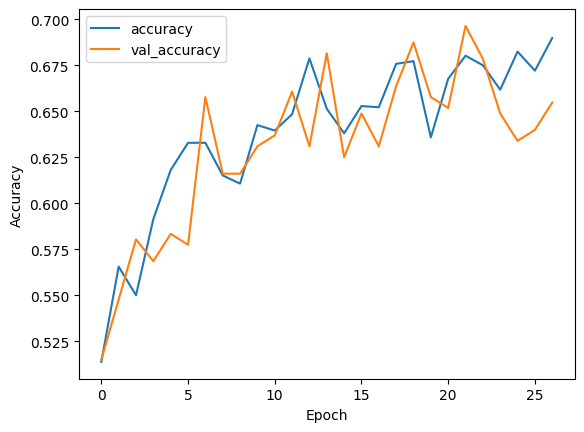

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_csv['label'] = predicted_labels
submission = test_csv[['file_id', 'label']]

In [ ]:
submission

,file_id,label
0,0.jpg,0
1,1.jpg,1
2,2.jpg,0
3,3.jpg,1
4,4.jpg,1
...,...,...
327,327.jpg,1
328,328.jpg,1
329,329.jpg,1
330,330.jpg,1


In [ ]:
submission['label'].value_counts(normalize=True)*100

label
1    71.385542
0    28.614458
Name: proportion, dtype: float64

In [ ]:
submission['file_id'] = submission['file_id'].str.replace('.jpg', '')
submission['file_id'] = submission['file_id'].astype(int)

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   file_id  332 non-null    int64
 1   label    332 non-null    int64
dtypes: int64(2)
memory usage: 5.3 KB


In [ ]:
submission.to_csv('/content/drive/MyDrive/PES_hackathon/Deeplearning/submission.csv', index=False)